# Classification. Linear models and KNN

In [55]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

In [57]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import warnings
from sklearn import set_config

warnings.filterwarnings('ignore')
set_config(display='diagram')
SEED = 42

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [58]:
from sklearn.exceptions import NotFittedError

In [59]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.history_loss = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        sigmoid = 1 / (1 + np.exp(-X@weights))
        return sigmoid
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        N = x.shape[0]
        loss_part = 0
        for sample in range(N):
          loss_part += np.log(1 + np.exp(-(weights@x[sample])*y[sample]))
                                
        loss = 1/N * loss_part + 1/(2*self.C) * np.linalg.norm(weights**2)
        #loss = 1/x.shape[0] * sum(np.log(1 + np.exp(-(X@weights)@y))) + 1/(2*self.C) * np.sqrt(sum(weights**2))
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        N = X_ext.shape[0]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            self.history_loss.append(self.get_loss(X_ext, self.weights_, y))
            delta_part = np.zeros(num_features) 
            for sample in range(N):
                delta_part += y[sample]*X_ext[sample]*(1 - 1/(1 + np.exp(-(self.weights_@X_ext[sample])*y[sample])))
                                
            delta =  -1/N * delta_part + self.weights_/self.C
            #delta = -1/N * y.T@X_ext*(1 - 1/(1 + np.exp(-(X_ext@self.weights_)@y))) + self.weights_/self.C
            self.weights_ -= self.eta * delta
            if self.tol > np.linalg.norm(self.eta * delta):
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = self.predict_proba(X)
        y = np.where(y < 0.5, -1, 1)
        return y

In [60]:
from sklearn import datasets
from sklearn import metrics

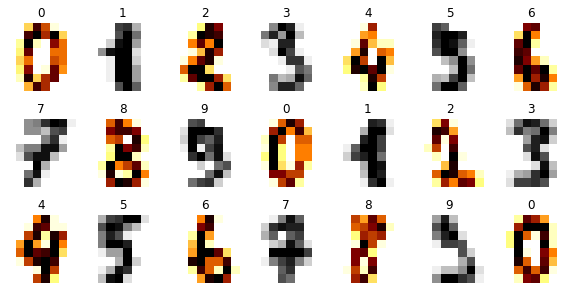

In [61]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [62]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [63]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [64]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [65]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [66]:
lr_clf.fit(X_train, y_train)

In [67]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [68]:
model = CustomLogisticRegression()

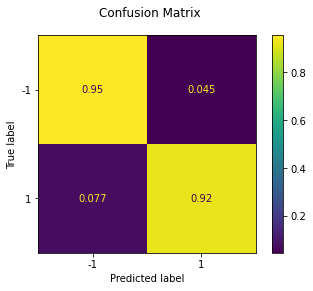

In [69]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [70]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [71]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

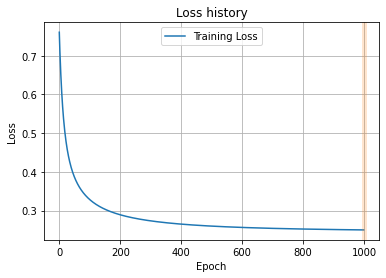

In [72]:
max_iter=1000
epoch = [i for i in range(max_iter)]
plt.plot(epoch, model.history_loss, label='Training Loss')
plt.axvline(epoch[np.argmin(model.history_loss)], color='C1', lw=5, alpha=0.2)
plt.grid(True)
plt.title('Loss history')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [73]:
#ETA = np.linspace(0, 0.1, 20)
ETA = np.linspace(0, 0.03, 20)
loss, f1, time = [], [], []

for eta in tqdm(ETA):
  start_time = datetime.now()
  logreg = CustomLogisticRegression(eta = eta)
  logreg.fit(X_train, y_train)
  end_time = datetime.now()

  loss.append(logreg.history_loss[-1])
  f1.append(f1_score(y_test, logreg.predict(X_test)))
  time.append(end_time - start_time)

100%|██████████| 20/20 [06:22<00:00, 19.12s/it]


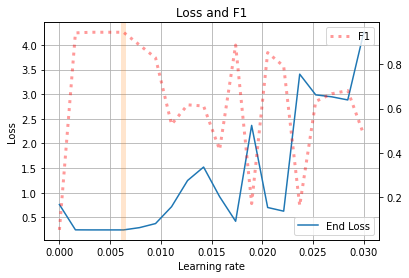

In [74]:
plt.plot(ETA, loss, label='End Loss')
plt.axvline(ETA[np.argmin(loss)], color='C1', lw=5, alpha=0.2)
plt.grid(True)
plt.title('Loss and F1')
plt.legend()
plt.xlabel('Learning rate')
plt.ylabel('Loss')

plt.twinx()
plt.plot(ETA, f1, alpha=0.4, lw=3, ls='dotted', color='red', label='F1') 
plt.legend();

At the optimal value of the learning rate, the minimum loss and the best f1 are achieved. Up to the optimal value of the learning rate: as the learning rate increases, the loss decreases, and f1 increases. After the optimal value of the learning rate: as the learning rate increases, the loss increases, and f1 decreases. That is, initially, with an increase in the learning rate, the quality of the model increases, but after the optimum, the opposite situation is observed.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [75]:
C = np.linspace(1, 5, 20)
loss_C, f1_C = [], []
for c in tqdm(C):
  logreg = CustomLogisticRegression(C = c)
  logreg.fit(X_train, y_train)
  loss_C.append(logreg.history_loss[-1])
  f1_C.append(f1_score(y_test, logreg.predict(X_test)))

100%|██████████| 20/20 [06:45<00:00, 20.26s/it]


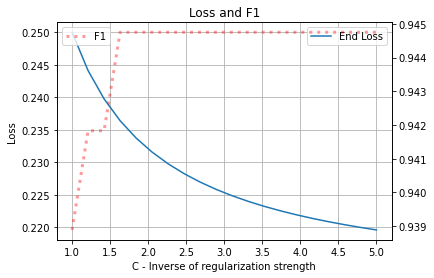

In [76]:
plt.plot(C, loss_C, label='End Loss')
plt.grid(True)
plt.title('Loss and F1')
plt.legend()
plt.xlabel('C - Inverse of regularization strength')
plt.ylabel('Loss')

plt.twinx()
plt.plot(C, f1_C, alpha=0.4, lw=3, ls='dotted', color='red', label='F1') 
plt.legend();

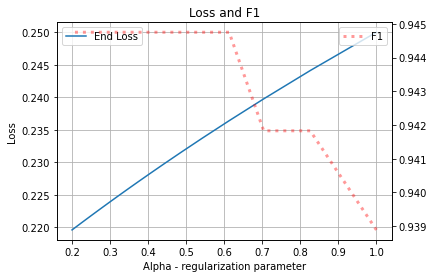

In [77]:
alpha = 1/C
plt.plot(alpha, loss_C, label='End Loss')
plt.grid(True)
plt.title('Loss and F1')
plt.legend()
plt.xlabel('Alpha - regularization parameter')
plt.ylabel('Loss')

plt.twinx()
plt.plot(alpha, f1_C, alpha=0.4, lw=3, ls='dotted', color='red', label='F1') 
plt.legend();

With the growth of C, the quality of the model increases, that is, with the growth of alpha, it will decrease. With loss the situation is reversed.

**(0.5 points)** Compare zero initialization and random initialization. 

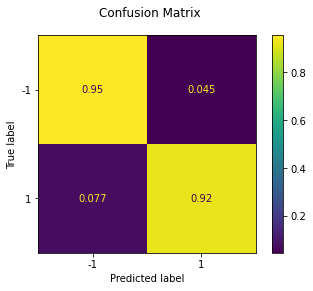

0.9109255393180237 0.9388888888888889


In [78]:
model_random_init = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(model_random_init, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

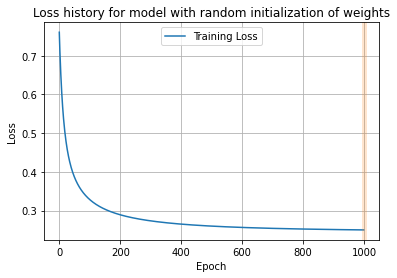

In [79]:
plt.plot(epoch, model_random_init.history_loss, label='Training Loss')
plt.axvline(epoch[np.argmin(model_random_init.history_loss)], color='C1', lw=5, alpha=0.2)
plt.grid(True)
plt.title('Loss history for model with random initialization of weights')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

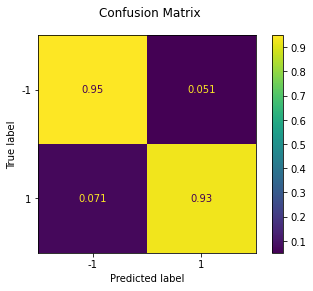

0.9116214335421016 0.9388888888888889


In [80]:
model_zero_init = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model_zero_init, X_train, y_train, X_test, y_test)
print(train_acc, test_acc)

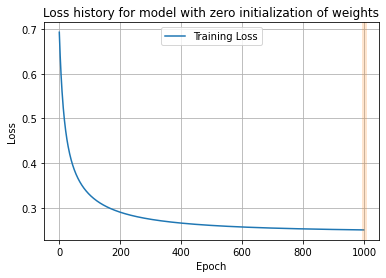

In [81]:
plt.plot(epoch, model_zero_init.history_loss, label='Training Loss')
plt.axvline(epoch[np.argmin(model_zero_init.history_loss)], color='C1', lw=5, alpha=0.2)
plt.grid(True)
plt.title('Loss history for model with zero initialization of weights')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

With zero initialization, the quality of the model on train has improved slightly. Usually a different way of initializing weights affects the convergence of the algorithm. In our case, both methods lead to a successful outcome.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [82]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        n_samples = X.shape[0]
        k_samples = Y.shape[0] 
        P = np.zeros((n_samples, k_samples)) 

        for i in range(n_samples):
          for j in range(k_samples):
            P[i][j] = np.sqrt(np.sum((X[i][:] - Y[j][:])**2))
        
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = np.zeros(len(self.classes_))

        weights_sort = np.column_stack((y, weights))
        weights_sort = weights_sort[weights_sort[:, 1].argsort()[::-1][:]]
        weights_sort = weights_sort[:self.n_neighbors][:].T
        y, weights = np.array(weights_sort[0]), np.array(weights_sort[1]).astype('float64')

        for idx, cl in enumerate(self.classes_):
          mask = np.where(y == cl, True, False)
          p[idx] = np.sum(weights[mask])   
      
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps)
                
            n_samples = X.shape[0]
            y = np.zeros((n_samples, self.classes_.shape[0]))

            for sample in range(n_samples):
              p = self.get_class_weights(self.y, weights_of_points[sample])
              y[sample] = p/np.sum(p)

            return y
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = self.predict_proba(X)
        results = np.zeros(y.shape[0])

        for idx in range(y.shape[0]):
          results[idx] = self.classes_[np.argmax(y[idx])]

        return results

In [83]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [84]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [85]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

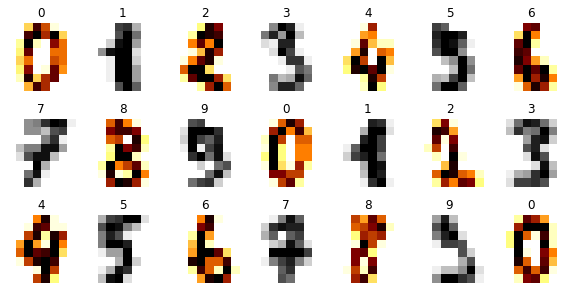

In [86]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [87]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [88]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

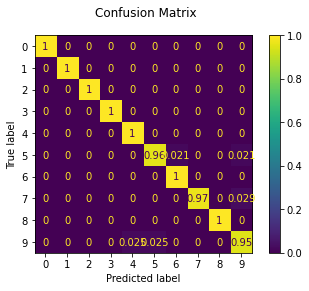

In [89]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [90]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

The model confuses 4 with 9, 5 with 9, 6 with 5, 9 with 7. Because these are visually similar digits, therefore, a set of 64 pixel values for these digits will also be similar.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [91]:
NEIGBORS = np.linspace(1, 50, 50)
f1_NEIGBORS, pred_proba_sum, pred_proba_mean = [], [], []
for n in tqdm(NEIGBORS):
  knn = CustomKNeighborsClassifier(n_neighbors=int(n), weights='distance')
  knn.fit(X_train, y_train)
  pred_proba_sum.append(np.sum(knn.predict_proba(X_test), axis=0))
  pred_proba_mean.append(np.mean(knn.predict_proba(X_test), axis=0))
  f1_NEIGBORS.append(f1_score(y_test, knn.predict(X_test), average='macro'))

100%|██████████| 50/50 [12:26<00:00, 14.94s/it]


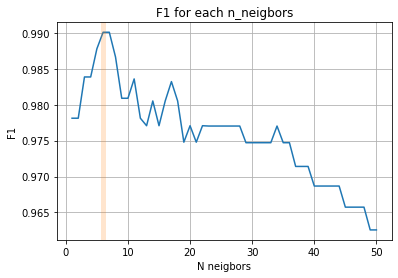

In [92]:
plt.plot(NEIGBORS, f1_NEIGBORS)
plt.axvline(NEIGBORS[np.argmax(f1_NEIGBORS)], color='C1', lw=5, alpha=0.2)
plt.grid(True)
plt.title('F1 for each n_neigbors')
plt.xlabel('N neigbors')
plt.ylabel('F1');

In [93]:
result_predict_proba_sum = pd.DataFrame(index=[i for i in range(1,51)], data=pred_proba_sum)
result_predict_proba_mean = pd.DataFrame(index=[i for i in range(1,51)], data=pred_proba_mean)

print('Sum the output probabilities for each class for different n_neighbors')
result_predict_proba_sum

Sum the output probabilities for each class for different n_neighbors


,0,1,2,3,4,5,6,7,8,9
1,33.000000,30.000000,33.000000,35.000000,46.000000,47.000000,36.000000,33.000000,28.000000,39.000000
2,33.000000,29.500732,33.000000,35.000000,46.499268,46.036459,36.000000,33.000000,28.496771,39.466770
3,33.000000,29.644540,33.000000,34.697253,46.345748,46.627675,35.698679,33.314856,28.652869,39.018379
4,33.000000,29.295027,33.000000,34.301792,46.262327,47.374861,35.315475,33.474618,29.199421,38.776481
5,33.000000,29.065181,33.000000,34.237431,46.380595,47.313661,35.439147,33.762539,29.127952,38.673493
6,33.000000,29.660692,33.000000,34.049541,46.167929,47.270347,35.524844,33.642173,28.816009,38.868466
7,33.000000,29.937488,32.999484,33.792249,46.017675,47.238564,35.454243,33.673213,28.848494,39.038589
8,33.000000,29.729595,33.106773,33.927604,46.017151,47.088669,35.403457,33.713962,29.179617,38.833173
9,33.000000,30.073102,32.907847,33.832221,46.005981,46.691576,35.462085,33.500011,28.960588,39.566588
10,33.000000,30.420467,32.736513,34.033142,46.089836,46.362743,35.338120,33.638479,28.779113,39.601586


In [94]:
print('Mean the output probabilities for each class for different n_neighbors')
result_predict_proba_mean

Mean the output probabilities for each class for different n_neighbors


,0,1,2,3,4,5,6,7,8,9
1,0.091667,0.083333,0.091667,0.097222,0.127778,0.130556,0.100000,0.091667,0.077778,0.108333
2,0.091667,0.081946,0.091667,0.097222,0.129165,0.127879,0.100000,0.091667,0.079158,0.109630
3,0.091667,0.082346,0.091667,0.096381,0.128738,0.129521,0.099163,0.092541,0.079591,0.108384
4,0.091667,0.081375,0.091667,0.095283,0.128506,0.131597,0.098099,0.092985,0.081110,0.107712
5,0.091667,0.080737,0.091667,0.095104,0.128835,0.131427,0.098442,0.093785,0.080911,0.107426
6,0.091667,0.082391,0.091667,0.094582,0.128244,0.131307,0.098680,0.093450,0.080044,0.107968
7,0.091667,0.083160,0.091665,0.093867,0.127827,0.131218,0.098484,0.093537,0.080135,0.108441
8,0.091667,0.082582,0.091963,0.094243,0.127825,0.130802,0.098343,0.093650,0.081054,0.107870
9,0.091667,0.083536,0.091411,0.093978,0.127794,0.129699,0.098506,0.093056,0.080446,0.109907
10,0.091667,0.084501,0.090935,0.094537,0.128027,0.128785,0.098161,0.093440,0.079942,0.110004


With the optimal value of the nearest neighbors, the quality of the model is the highest. Before this value, with the growth of n_neighbors, the quality of the model increases, and after it decreases. It is noticeable that changes in the number of nearest neighbors affect the predictions of the model, the probabilities for different classes change. Also, as the number of n_neighbors increases, these probabilities become less stable.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [95]:
NEIGBORS = np.linspace(1, 50, 50)
f1_distance, f1_uniform = [], []
for n in tqdm(NEIGBORS):
  knn_distance = CustomKNeighborsClassifier(n_neighbors=int(n), weights='distance')
  knn_uniform = CustomKNeighborsClassifier(n_neighbors=int(n), weights='uniform')
  knn_distance.fit(X_train, y_train)
  knn_uniform.fit(X_train, y_train)

  f1_distance.append(f1_score(y_test, knn_distance.predict(X_test), average='macro'))
  f1_uniform.append(f1_score(y_test, knn_uniform.predict(X_test), average='macro'))

100%|██████████| 50/50 [08:16<00:00,  9.92s/it]


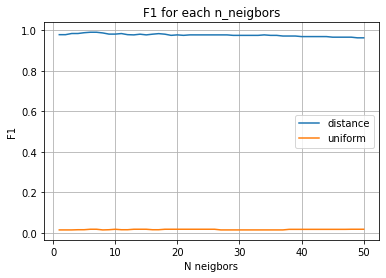

In [96]:
plt.plot(NEIGBORS, f1_distance, label = 'distance')
plt.plot(NEIGBORS, f1_uniform, label = 'uniform')
plt.legend()
plt.grid(True)
plt.title('F1 for each n_neigbors')
plt.xlabel('N neigbors')
plt.ylabel('F1');

In [97]:
all_els = X_test.shape[0]*X_test.shape[1]
zero_els = all_els - np.count_nonzero(X_test)
zero_els/all_els

0.49114583333333334

For our task, taking into account the distance to the object is important. When weights='uniform' the quality of the model drops a lot. When uniform weights are being used, each neighbor carries the same weight in calculating the prediction. However, in some cases (when you have sparse data), it may be beneficial to use distance-based weights. As in our case where there are 64 columns in X and many null values (almost half).

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

It would be possible to try using Manhattan distance for this task. Manhattan distance is usually preferred over the more common Euclidean distance when there is high dimensionality in the data.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

For the task of finding the shortest route in the city better using manhattan distance. Cosine metric is mainly used in Collaborative Filtering based recommendation systems to offer future recommendations to users.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [98]:
PATH = ""

In [99]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [100]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

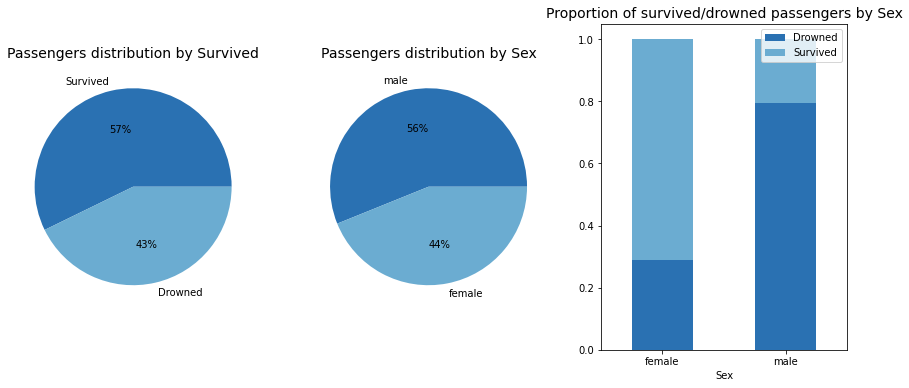

In [101]:
palette = sns.color_palette("RdBu_r", 7)
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
plt.title('Passengers distribution by Survived', fontsize=14)
plt.pie(data.Survived.value_counts(), labels=['Survived', 'Drowned'], colors=palette, autopct='%.0f%%')

ax2 = fig.add_subplot(132)
plt.title('Passengers distribution by Sex', fontsize=14)
plt.pie(data.Sex.value_counts(), labels=data.Sex.unique(), colors=palette, autopct='%.0f%%')

ax3 = fig.add_subplot(133)
plt.title('Proportion of survived/drowned passengers by Sex', fontsize=14)
sex = data.groupby('Sex')['Survived'].value_counts(normalize=True).unstack()
sex = sex.sort_values(by=1, ascending=False)
sex.plot.bar(stacked='True', color=palette, ax=ax3)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation = False);

In the training data set: 56% - male, 44% - female, 57% - survived, 43% - drowned. Most people are male. Female has a lot higher rate of survival compared with male. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

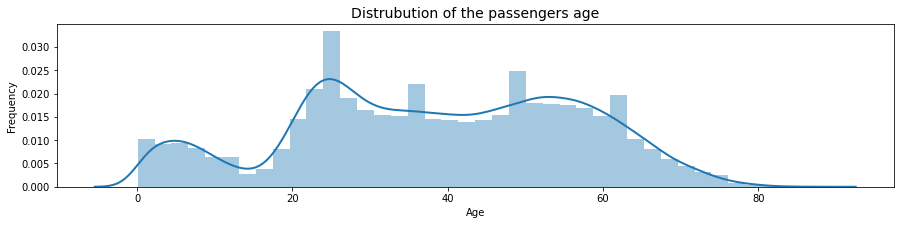

In [102]:
plt.figure(figsize=(15, 3))
sns.distplot(data.Age, kde_kws={"lw": 2}, bins=40)
plt.title('Distrubution of the passengers age', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Frequency');

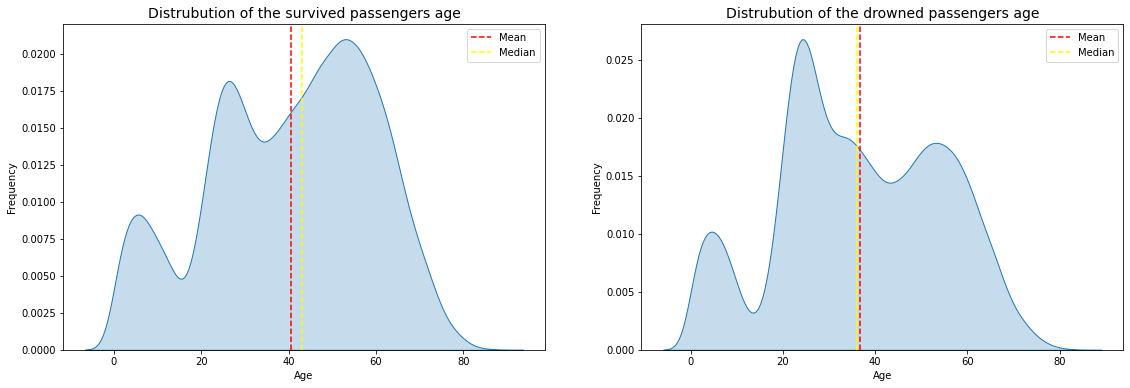

In [103]:
fig = plt.figure(figsize=(19, 6))

ax1 = fig.add_subplot(121)
sns.kdeplot(data[data.Survived == 1].Age, shade=True)
ax1.axvline(data[data.Survived == 1].Age.mean(),linestyle = '--', color = 'red', label = 'Mean')
ax1.axvline(data[data.Survived == 1].Age.median(),linestyle = '--', color = 'yellow', label = 'Median')
plt.title('Distrubution of the survived passengers age', fontsize=14)
plt.legend(['Mean','Median'])
plt.xlabel('Age')
plt.ylabel('Frequency');

ax1 = fig.add_subplot(122)
sns.kdeplot(data[data.Survived == 0].Age, shade=True)
ax1.axvline(data[data.Survived == 0].Age.mean(),linestyle = '--', color = 'red', label = 'Mean')
ax1.axvline(data[data.Survived == 0].Age.median(),linestyle = '--', color = 'yellow', label = 'Median')
plt.title('Distrubution of the drowned passengers age', fontsize=14)
plt.legend(['Mean','Median'])
plt.xlabel('Age')
plt.ylabel('Frequency');

In [104]:
print('The survived passengers: mean age - {0:.1f}, median age - {1:.1f}'.format(data[data.Survived == 1].Age.mean(), data[data.Survived == 1].Age.median()))
print('The drowned passengers: mean age - {0:.1f}, median age - {1:.1f}'.format(data[data.Survived == 0].Age.mean(), data[data.Survived == 0].Age.median()))

The survived passengers: mean age - 40.6, median age - 43.0
The drowned passengers: mean age - 36.7, median age - 36.0


Distributions for survived and deceased passengers differ. As an assumption, the elderly were the first to be put into boats (because of this, the average values are shifting), and the young helped to evacuate passengers. If we turn to the second task in the course (eda), we then found out that Pclass and Fare also affect the survival of passengers, and for older people these values are higher, respectively, and the chance of survival too.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

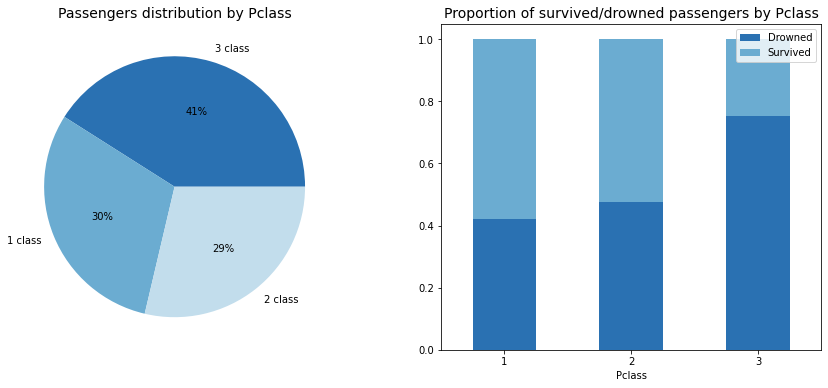

In [105]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
plt.title('Passengers distribution by Pclass', fontsize=14)
labels = [str(i) + ' class' for i in data.Pclass.value_counts().index.to_list()]
plt.pie(data.Pclass.value_counts(), labels=labels, colors=palette, autopct='%.0f%%')

ax2 = fig.add_subplot(122)
plt.title('Proportion of survived/drowned passengers by Pclass', fontsize=14)
pclass = data.groupby('Pclass')['Survived'].value_counts(normalize=True).unstack()
pclass = pclass.sort_values(by=1, ascending=False)
pclass.plot.bar(stacked='True', color=palette, ax=ax2)
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation = False);

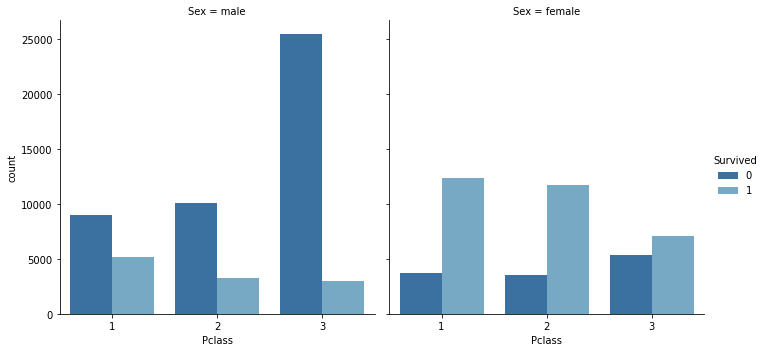

In [106]:
sns.catplot(x = 'Pclass', hue = 'Survived', col = 'Sex', kind = 'count', data = data , palette=palette);

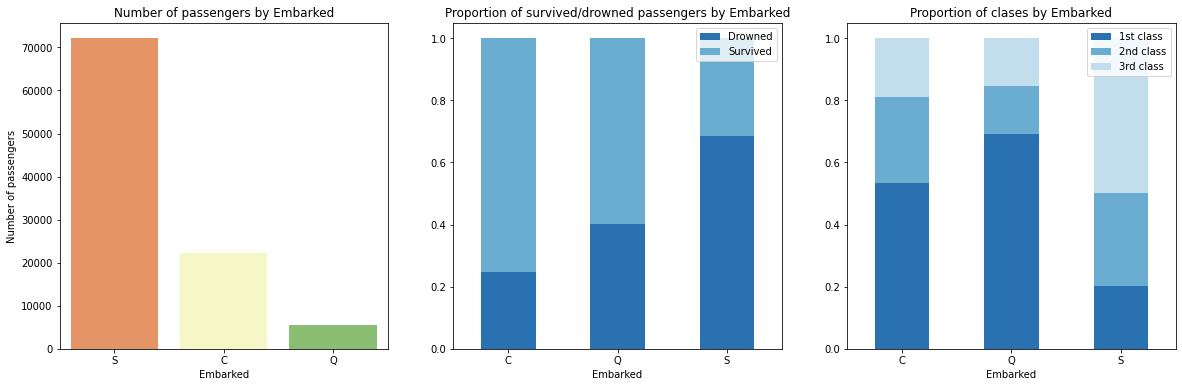

In [107]:
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
sns.countplot(data['Embarked'], palette='RdYlGn', ax=ax1)
plt.title('Number of passengers by Embarked')
plt.ylabel('Number of passengers')

ax2 = fig.add_subplot(132)
embarked = data.groupby('Embarked')['Survived'].value_counts(normalize=True)
embarked = embarked.unstack().sort_values(by=1, ascending=False)
embarked.plot(kind='bar', stacked='True', color=palette, ax=ax2)
plt.title('Proportion of survived/drowned passengers by Embarked')
plt.legend(('Drowned', 'Survived'))
plt.xticks(rotation=False)

ax3 = fig.add_subplot(133)
embarked = data.groupby('Embarked')['Pclass'].value_counts(normalize=True)
embarked = embarked.unstack().sort_index()
embarked.plot(kind='bar', stacked='True', color=palette, ax=ax3)
plt.legend(('1st class', '2nd class', '3rd class'))
plt.title('Proportion of clases by Embarked')
plt.xticks(rotation=False);

People boarding on class 3 has a low chance of survival whilst class 1 has the highest chance of survival. Most of the male passengers of 3rd class drowned, and the female on board almost all survived. There were overall more males than females on board, it is fair for each ticket class, but in the 3rd class number of males more than twice bigger than females. 

Most people boarded at Southampton. People boarded at Cherbourg has a highest rate of survival whilst people from Southampton has the lowest rate of survival People from Cherbourg mostly the class 1 whilst people from Southampton mostly the class 3. The vast majority of passengers from Queenstown are 1st class.

More detailed eda can be seen here https://github.com/kmagritte/RSSchool_EDA/blob/main/eda.ipynb

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [108]:
print('Missing values per columns in train dataset')
for col in data.columns:
    print('{0}: {1:.2f} %'.format(col, data[col].isnull().sum()/data.shape[0] * 100))

Missing values per columns in train dataset
Survived: 0.00 %
Pclass: 0.00 %
Name: 0.00 %
Sex: 0.00 %
Age: 3.29 %
SibSp: 0.00 %
Parch: 0.00 %
Ticket: 4.62 %
Fare: 0.13 %
Cabin: 67.87 %
Embarked: 0.25 %


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

The columns having null values are: Age, Ticket, Fare, Cabin, Embarked. Most of the missing value come from Cabin feature. It was decided to remove the column Ticket due to low information content. The missing values for Age and Fare are replaced by the median for each Pclass. Missing values for columns Cabin and Embarked was filled with new separate category. The way to replace missing values in a categorical variable by creating a new category is a good method to avoid losing an important feature. Replacing the values with the median or average for numeric features may affect their distribution, but we take into account other features when filling in to distinguish this.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Let's process the missing values. We will delete the Name column because of its low informativeness. Let's work with the signs Cabin, Parch, SibSp.

In [109]:
def prepare_features(data):
    data['Age'] = data['Age'].fillna(data.groupby(['Pclass', 'Sex'])['Age'].transform('mean'))
    data['Fare'] = data['Fare'].fillna(data.groupby('Pclass')['Fare'].transform('mean'))

    embark_mapping = {"S" : "Southampton", "C" : "Cherbourg",  "Q" : "Queenstown", np.nan : "Not Embarked"}
    data = data.replace({"Embarked": embark_mapping})

    data['Cabin'] = data['Cabin'].fillna("No Cabin")
    data['Cabin'] = data['Cabin'].str[0]

    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

    data['HasFamily'] = data.apply(lambda x: 1 if x.FamilySize != 1 else 0, axis=1)
    #data['HasCabin'] = data.apply(lambda x: 0 if x.FamilySize == 'Not Embarked' else 1, axis=1)


    bins = [0, 5, 17, 30, 50, 100]
    labels = ["Baby", "Children", "Young Adult", "Middle Aged", "Senior"]
    data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels) 

    bins = [0, 25, 90, 150, np.inf]
    labels = ["Low", "Middle", "High", "Very high"]
    data['FareGroup'] = pd.cut(data['Fare'], bins=bins, labels=labels) 

    bins = [0, 1, 4, 7, np.inf]
    labels = ["Single", "Usual", "Big", "Very big"]
    data['FamilyGroup'] = pd.cut(data['FamilySize'], bins=bins, labels=labels) 

    data.drop(['Ticket', 'Name'], axis=1, inplace=True)
    return data

In [110]:
data = prepare_features(data)

In [111]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,HasFamily,AgeGroup,FareGroup,FamilyGroup
PassengerId,,,,,,,,,,,,,,
0,1,1,male,42.254922,2,0,27.14,C,Southampton,3,1,Middle Aged,Middle,Usual
1,0,3,male,34.038757,0,0,13.35,N,Southampton,1,0,Middle Aged,Low,Single
2,0,3,male,0.330000,1,2,71.29,N,Southampton,4,1,Baby,Middle,Usual
3,0,3,male,19.000000,0,0,13.04,N,Southampton,1,0,Young Adult,Low,Single
4,1,3,male,25.000000,0,0,7.76,N,Southampton,1,0,Young Adult,Low,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,female,62.000000,0,0,14.86,D,Cherbourg,1,0,Senior,Low,Single
99996,0,2,male,66.000000,0,0,11.15,N,Southampton,1,0,Senior,Low,Single
99997,0,3,male,37.000000,0,0,9.95,N,Southampton,1,0,Middle Aged,Low,Single


In [112]:
y = data.Survived
data.drop('Survived', axis=1, inplace=True)
X = data.copy()

Preprocessing of features.

In [113]:
# for col in categorical_features:
#   le = LabelEncoder()
#   data[col] = le.fit_transform(data[col])

In [114]:
# data.corr()

In [115]:
numeric_features = ['Age','Pclass',	'SibSp',	'Parch',	'Fare',	'FamilySize',	'HasFamily']
categorical_features = ['Sex', 'Cabin', 'Embarked', 'AgeGroup',	'FareGroup',	'FamilyGroup']

# numeric_features = ['Pclass', 'Age']
# categorical_features = ['Sex', 'Embarked']

preprocessor = ColumnTransformer(
            transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)]) 

X = preprocessor.fit_transform(X)

Divide the data set into train and test (90% / 10%).

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

Making two models (KNN and Logistic Regression) to predict the survival.

In [117]:
knn = KNeighborsClassifier()
lr = LogisticRegression()

In [118]:
results_knn = cross_validate(knn, 
                             X_train, y_train, cv=3,
                             return_train_score=True,
                             scoring='accuracy')

results_lr = cross_validate(lr, 
                            X_train, y_train, cv=3,
                            return_train_score=True,
                            scoring='accuracy')

In [119]:
results_knn

{'fit_time': array([0.01600051, 0.01737618, 0.01737547]),
 'score_time': array([37.73022866, 37.46131086, 39.90735149]),
 'test_score': array([0.74646667, 0.74626667, 0.7489    ]),
 'train_score': array([0.82056667, 0.81926667, 0.81718333])}

In [120]:
results_lr

{'fit_time': array([1.51274776, 1.51077986, 1.41699219]),
 'score_time': array([0.00792289, 0.00735593, 0.00716758]),
 'test_score': array([0.7707    , 0.7741    , 0.77186667]),
 'train_score': array([0.77396667, 0.7723    , 0.77101667])}

In [121]:
knn.fit(X_train, y_train)
lr.fit(X_train, y_train);

In [122]:
accuracy_score(y_test, knn.predict(X_test))

0.7525

In [123]:
accuracy_score(y_test, lr.predict(X_test))

0.7794

The quality for logistic regression is better than for knn on a validation sample and test set, let's try to set up more hyperparameters.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [133]:
param_grid_lr = {
    'C': list(np.linspace(0.03, 0.08, 20)),
    'max_iter': list(range(50, 60, 10)),
    'solver': ['lbfgs']
}

param_grid_knn = {
    'n_neighbors':[30, 35, 40],
    'weights':['uniform', 'distance']
}

In [125]:
b = GridSearchCV(knn, param_grid_knn, scoring='accuracy', cv=3).fit(X_train, y_train)
b.best_estimator_

KNeighborsClassifier(n_neighbors=40)

In [134]:
a = GridSearchCV(lr, param_grid_lr, scoring='accuracy', cv=3).fit(X_train, y_train)
a.best_estimator_

LogisticRegression(C=0.07210526315789473, max_iter=50)

In [135]:
a.best_estimator_.solver

'lbfgs'

In [136]:
best_lr = a.best_estimator_
best_lr.fit(X_train, y_train);

In [137]:
best_knn = b.best_estimator_
best_knn.fit(X_train, y_train);

In [138]:
accuracy_score(y_test, best_lr.predict(X_test))

0.7789

In [139]:
accuracy_score(y_test, best_knn.predict(X_test))

0.7763

In [140]:
sub = pd.read_csv('sample_submission.csv')
sub_test = pd.read_csv('test.csv').set_index('PassengerId')
sub_test = prepare_features(sub_test)
sub_test = preprocessor.transform(sub_test)
predictions = best_lr.predict(sub_test)
sub['Survived'] = predictions
sub.to_csv('submission.csv', index=False)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

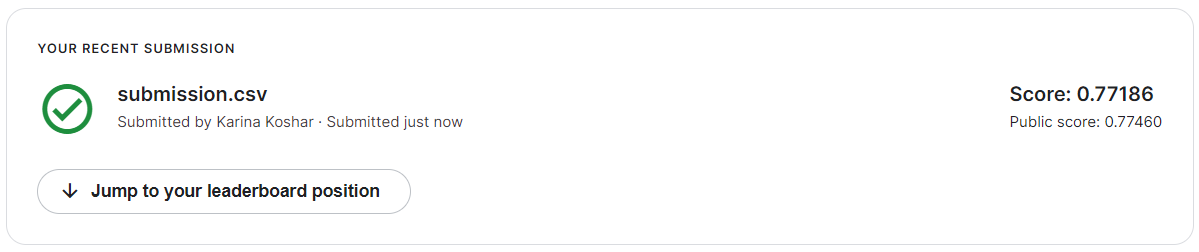